<a href="https://colab.research.google.com/github/ShotaSasaki-HCU/Prog2kakushin/blob/main/work2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

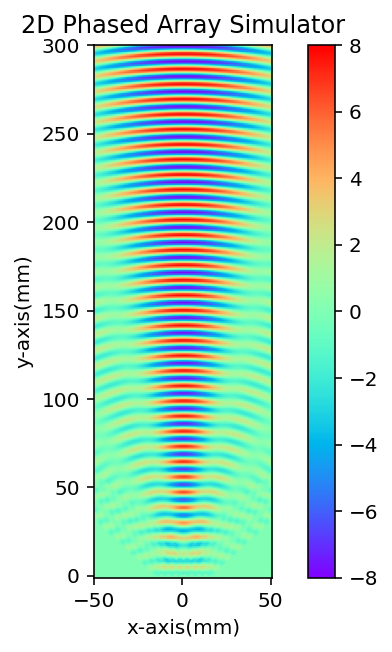

In [34]:
# Numpyの練習
# 2D Phased Array Simulator

import numpy as np
from matplotlib import pyplot as plt

range_x_R = 50 # x軸方向レンジ右(mm)
range_x_L = -50 # x軸方向レンジ左(mm)
range_y_T = 300 # y軸方向レンジ上(mm)
range_y_B = 0 # y軸方向レンジ下(mm)
calc_width = 1 # 計算幅(mm)

A = 1 # 送信波の振幅
f = 40000 # 送信波の周波数(Hz)
t = 0.0 # 時間(s)
v = 340.29 * 1000 # 送信波の速さ(mm/s)

tr_num = 8 # 送信素子数（個）
tr_directivity = np.deg2rad(95) # 送信素子指向性(rad)
tr_clearance = (v / f) / 2 # 送信素子間隔(mm)
tr_x_coord = [] # 送信素子のx座標（y座標は0で固定）

beam_direction = np.deg2rad(90) # 合成波の指向方向(rad)

# 指定されたレンジを満たす（必要最小限は超える）Numpy２次元配列を0埋めで作成する。
sim_result = np.zeros((int(np.ceil((range_y_T - range_y_B) / calc_width) + 1), int(np.ceil((range_x_R - range_x_L) / calc_width) + 1)))

# 送信素子をx軸上に原点が中心となる様に配置する。それらの座標を計算してtr_x_coordに格納する。
if (tr_num % 2) == 1: # 送信素子数が奇数個のとき
  for n in range(0, tr_num):
    tr_x_coord.append(-((tr_num // 2) * tr_clearance) + (n * tr_clearance))
else: # 送信素子数が偶数個のとき
  for n in range(0, tr_num):
    tr_x_coord.append(-(((tr_num // 2) * tr_clearance) - (tr_clearance / 2)) + (n * tr_clearance))

calc_x = range_x_L # 計算するx座標を初期化
calc_y = range_y_T # 計算するy座標を初期化
row = 0 # 行インデックス初期化
column = 0 # 列インデックス初期化
for num in range(0, tr_num): # 送信素子それぞれについて左端から順次計算していく。
  phase_diff = num * tr_clearance * np.sin(beam_direction - (np.pi / 2)) # 位相差
  while calc_y > (range_y_B - calc_width):
    while calc_x < (range_x_R + calc_width):
      vec = np.array([calc_x, calc_y]) - np.array([tr_x_coord[num], 0]) # (計算座標) - (送信素子の座標)
      from_tr = np.arctan2(vec[0], vec[1]) # 送信素子から見た計算座標の向き（y軸が0(rad)で、時計回りが正・反時計回りが負となる。）
      if np.abs(from_tr) <= (tr_directivity / 2): # 計算座標が送信素子の指向性の範囲に入っている場合
        sim_result[row][column] += A * np.sin(2 * np.pi * f * (t - (np.linalg.norm(vec) / v) + (phase_diff / v))) # 波の式
      calc_x += calc_width # 次の計算座標へ（x軸の正方向へ）
      column += 1
    calc_x = range_x_L # 計算するx座標を初期化
    column = 0 # 列インデックス初期化
    calc_y -= calc_width # 次の計算座標へ（y軸の負方向へ）
    row += 1
  calc_y = range_y_T # 計算するy座標を初期化
  row = 0 # 行インデックス初期化

fig, ax = plt.subplots(dpi=144)
im = ax.imshow(sim_result, cmap='rainbow', aspect='equal', vmin=-A*tr_num, vmax=A*tr_num, extent=(range_x_L, range_x_L+(calc_width*sim_result.shape[1]), range_y_T-(calc_width*sim_result.shape[0]), range_y_T))
ax.set_title('2D Phased Array Simulator')
ax.set_xlabel('x-axis(mm)')
ax.set_ylabel('y-axis(mm)')
plt.colorbar(im)
plt.show()
